# **ARI 6:2:2**

## **Thuật toán AAE**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
fileName = '/content/ARI-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]


In [ ]:
dataset.head()

,Date,Price,Open,High,Low,Vol.,Change %
2128,01/02/2015,16.54,16.49,16.55,16.35,184.56K,1.10%
2127,01/05/2015,16.51,16.47,16.63,16.45,387.43K,-0.18%
2126,01/06/2015,16.42,16.60,16.64,16.37,225.81K,-0.55%
2125,01/07/2015,16.63,16.48,16.65,16.44,492.81K,1.28%
2124,01/08/2015,16.49,16.69,16.69,16.45,440.70K,-0.84%


In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)

In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)


In [ ]:
data_transform = dataset.drop('Date', axis=1)
data_transform = data_transform.drop('Open', axis=1)
data_transform = data_transform.drop('Vol.', axis=1)
# data_transform = data_transform.drop('Change %', axis=1)
# data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
data_transform=scaler.fit_transform(np.array(data_transform))

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 4

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    # sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity




In [ ]:
batch_size=512
n_epochs=50

In [ ]:
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)


In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

In [ ]:
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )

[Epoch 4/50] [Batch 0/5] [D loss: 0.685623] [G loss: 0.124850]
[Epoch 4/50] [Batch 1/5] [D loss: 0.685128] [G loss: 0.169978]
[Epoch 4/50] [Batch 2/5] [D loss: 0.690018] [G loss: 0.242292]
[Epoch 4/50] [Batch 3/5] [D loss: 0.699014] [G loss: 0.167520]
[Epoch 4/50] [Batch 4/5] [D loss: 0.688109] [G loss: 0.293190]
[Epoch 9/50] [Batch 0/5] [D loss: 0.678914] [G loss: 0.070743]
[Epoch 9/50] [Batch 1/5] [D loss: 0.680909] [G loss: 0.135947]
[Epoch 9/50] [Batch 2/5] [D loss: 0.675824] [G loss: 0.134671]
[Epoch 9/50] [Batch 3/5] [D loss: 0.681503] [G loss: 0.129385]
[Epoch 9/50] [Batch 4/5] [D loss: 0.697035] [G loss: 0.234515]
[Epoch 14/50] [Batch 0/5] [D loss: 0.654295] [G loss: 0.053043]
[Epoch 14/50] [Batch 1/5] [D loss: 0.648459] [G loss: 0.130897]
[Epoch 14/50] [Batch 2/5] [D loss: 0.649100] [G loss: 0.093655]
[Epoch 14/50] [Batch 3/5] [D loss: 0.668025] [G loss: 0.155134]
[Epoch 14/50] [Batch 4/5] [D loss: 0.683296] [G loss: 0.263833]
[Epoch 19/50] [Batch 0/5] [D loss: 0.651021] [G lo

In [ ]:
# import matplotlib.pyplot as plt
# # Vẽ biểu đồ Discriminator Loss
# plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Discriminator Loss')
# plt.show()


In [ ]:
# # Vẽ biểu đồ Generator Loss
# plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Generator Loss')
# plt.show()

In [ ]:
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()

## **Thuật toán LSTM**


In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
20/20 [==============================] - 7s 62ms/step - loss: 0.1128 - val_loss: 0.0132
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0441 - val_loss: 0.0278
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0527
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0434
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0456
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0444
Epoch 7/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0426
Epoch 8/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.0411
Epoch 9/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0396
Epoch 10/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0359
Epoch 11/50
20/20 

In [ ]:
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)


In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 3ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

## **Đánh giá**

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.382459268077301
Testing RMSE: 0.6263239572632049
Testing MAE: 0.4272109810849454
Validation MAE: 0.31409084885541155
Testing MAPE: 3.8795289642060196
Validation MAPE: 2.655388727557074


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

## **kẾT QUẢ**

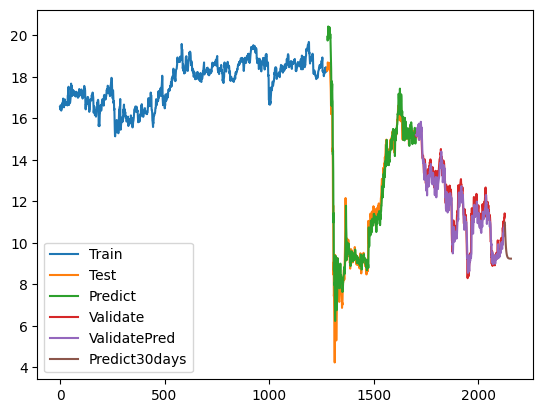

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# **ARE 6:2:2**

## **Thuật toán AAE**


In [1890]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1891]:
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [1892]:
fileName = '/content/ARE-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]


In [1893]:
dataset.head()

,Date,Price,Open,High,Low,Vol.,Change %
2128,01/02/2015,89.79,89.11,89.88,88.54,277.62K,1.18%
2127,01/05/2015,90.87,89.31,91.17,89.15,359.76K,1.20%
2126,01/06/2015,91.33,90.65,91.56,90.25,1.33M,0.51%
2125,01/07/2015,92.57,91.55,92.57,90.69,543.40K,1.36%
2124,01/08/2015,93.63,92.57,93.85,92.43,718.78K,1.15%


In [1894]:
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)

In [1895]:
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)


In [1896]:
data_transform = dataset.drop('Date', axis=1)
# data_transform = data_transform.drop('Open', axis=1)
data_transform = data_transform.drop('Vol.', axis=1)
# data_transform = data_transform.drop('Change %', axis=1)
data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)


In [1897]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [1898]:
data_transform=scaler.fit_transform(np.array(data_transform))

In [1899]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 4

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity




In [1900]:
batch_size=512
n_epochs=50

In [1901]:
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [1902]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)


In [1903]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

In [1904]:
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )

[Epoch 4/50] [Batch 0/5] [D loss: 0.648370] [G loss: 0.171625]
[Epoch 4/50] [Batch 1/5] [D loss: 0.631796] [G loss: 0.105395]
[Epoch 4/50] [Batch 2/5] [D loss: 0.637421] [G loss: 0.107772]
[Epoch 4/50] [Batch 3/5] [D loss: 0.618283] [G loss: 0.142547]
[Epoch 4/50] [Batch 4/5] [D loss: 0.650845] [G loss: 0.081581]
[Epoch 9/50] [Batch 0/5] [D loss: 0.614487] [G loss: 0.117618]
[Epoch 9/50] [Batch 1/5] [D loss: 0.590858] [G loss: 0.108956]
[Epoch 9/50] [Batch 2/5] [D loss: 0.555192] [G loss: 0.114140]
[Epoch 9/50] [Batch 3/5] [D loss: 0.549742] [G loss: 0.092619]
[Epoch 9/50] [Batch 4/5] [D loss: 0.629552] [G loss: 0.085013]
[Epoch 14/50] [Batch 0/5] [D loss: 0.620113] [G loss: 0.134530]
[Epoch 14/50] [Batch 1/5] [D loss: 0.598548] [G loss: 0.099031]
[Epoch 14/50] [Batch 2/5] [D loss: 0.562913] [G loss: 0.080471]
[Epoch 14/50] [Batch 3/5] [D loss: 0.502876] [G loss: 0.151586]
[Epoch 14/50] [Batch 4/5] [D loss: 0.618096] [G loss: 0.078569]
[Epoch 19/50] [Batch 0/5] [D loss: 0.645010] [G lo

In [1905]:
# import matplotlib.pyplot as plt
# # Vẽ biểu đồ Discriminator Loss
# plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Discriminator Loss')
# plt.show()


In [1906]:
# # Vẽ biểu đồ Generator Loss
# plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Generator Loss')
# plt.show()

In [1907]:
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()

## **Thuật toán LSTM**


In [1908]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [1909]:
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()


In [1910]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [1911]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [1912]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [1913]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [1914]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [1915]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [1916]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
20/20 [==============================] - 7s 63ms/step - loss: 0.0809 - val_loss: 0.1441
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0284 - val_loss: 0.0390
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0248
Epoch 4/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0279
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0267
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0264
Epoch 7/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0266
Epoch 8/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0263
Epoch 9/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0278
Epoch 10/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0259
Epoch 11/50
20/

In [1917]:
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)


In [1918]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 5ms/step


In [1919]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

## **Đánh giá**

In [1920]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 28.81628755248695
Testing RMSE: 29.760322080452053
Testing MAE: 28.507130765441467
Validation MAE: 24.345847875258503
Testing MAPE: 16.430672117713343
Validation MAPE: 13.649430526365977


In [1921]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [1922]:
lst_output

[[0.30174869298934937],
 [0.3069173991680145],
 [0.30891919136047363],
 [0.3096965551376343],
 [0.3099987208843231],
 [0.3101162612438202],
 [0.3101619780063629],
 [0.310179740190506],
 [0.3101866543292999],
 [0.3101893365383148],
 [0.3101904094219208],
 [0.3101908266544342],
 [0.31019094586372375],
 [0.31019100546836853],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909],
 [0.3101910352706909]]

## **kẾT QUẢ**

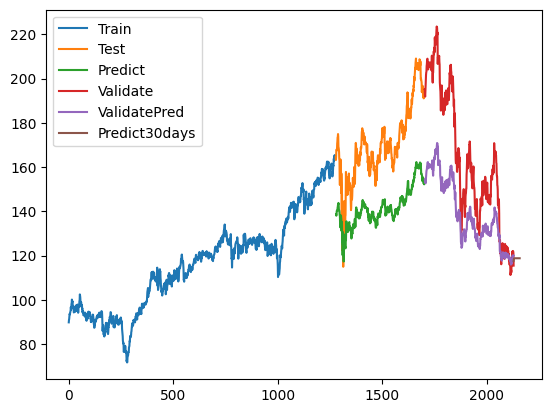

In [1923]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# **MAA 6:2:2**

## **Thuật toán AAE**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
fileName = '/content/MAA-Historical-Data.csv'
dataset = pd.read_csv(fileName)
dataset = dataset.iloc[::-1]



In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Vol.'
def convert_vol(value):
    if 'K' in value:
        # Loại bỏ ký tự 'K' và chuyển đổi thành giá trị số
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        # Loại bỏ ký tự 'M' và chuyển đổi thành giá trị số
        return float(value.replace('M', '')) * 1000000
    else:
        # Trường hợp không có đơn vị, giữ nguyên giá trị
        return float(value)

# Áp dụng hàm chuyển đổi vào cột 'Vol.' của dataset
dataset['Vol.'] = dataset['Vol.'].apply(convert_vol)

In [ ]:
# Chuyển đổi hàm để xử lý chuỗi 'Change %'
def convert_change(value):
    # Loại bỏ ký tự '%' và chuyển đổi thành giá trị số
    return float(value.replace('%', ''))

# Áp dụng hàm chuyển đổi bằng phương pháp map
dataset['Change %'] = dataset['Change %'].map(convert_change)


In [ ]:
data_transform = dataset.drop('Date', axis=1)
# data_transform = data_transform.drop('Open', axis=1)
data_transform = data_transform.drop('Vol.', axis=1)
data_transform = data_transform.drop('Change %', axis=1)
data_transform = data_transform.drop('Low', axis=1)
# data_transform = data_transform.drop('High', axis=1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
data_transform=scaler.fit_transform(np.array(data_transform))

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import random
import tensorflow as tf

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# dùng 'gpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# số chiều không gian tiềm ẩn
latent_dim = 1

# số chiều vector đầu vào.
embedding = 3

# sampling từ trung bình và độ lệch chuẩn.
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    # sampled_z = Variable(torch.randn((mu.size(0), latent_dim))).to(device)
    z = sampled_z * std + mu
    return z

class Encoder(nn.Module):
    def __init__(self, embedding):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(embedding, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self, embedding):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, embedding),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], -1)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity




In [ ]:
batch_size=512
n_epochs=50

In [ ]:
# Chuẩn bị dữ liệu huấn luyện (torch dùng đc gpu, numpy -> cpu)
tensor_data = torch.from_numpy(data_transform).float()  # Chuyển đổi thành Tensor và kiểu dữ liệu float

# Tạo DataLoader
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss().to(device)
pixelwise_loss = torch.nn.L1Loss().to(device)

# Initialize generator and discriminator
encoder = Encoder(embedding).to(device)
decoder = Decoder(embedding).to(device)
discriminator = Discriminator().to(device)


In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.0005
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

In [ ]:
import random
import numpy as np
import tensorflow as tf

# Khởi tạo list để lưu loss
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, imgs in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # print(real_imgs.shape)
        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (epoch + 1) % 5 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
          )

[Epoch 4/50] [Batch 0/5] [D loss: 0.572098] [G loss: 0.282921]
[Epoch 4/50] [Batch 1/5] [D loss: 0.612416] [G loss: 0.207775]
[Epoch 4/50] [Batch 2/5] [D loss: 0.625077] [G loss: 0.068381]
[Epoch 4/50] [Batch 3/5] [D loss: 0.617851] [G loss: 0.117101]
[Epoch 4/50] [Batch 4/5] [D loss: 0.593049] [G loss: 0.260517]
[Epoch 9/50] [Batch 0/5] [D loss: 0.498585] [G loss: 0.227818]
[Epoch 9/50] [Batch 1/5] [D loss: 0.565717] [G loss: 0.090372]
[Epoch 9/50] [Batch 2/5] [D loss: 0.606138] [G loss: 0.111451]
[Epoch 9/50] [Batch 3/5] [D loss: 0.616360] [G loss: 0.077883]
[Epoch 9/50] [Batch 4/5] [D loss: 0.615737] [G loss: 0.140351]
[Epoch 14/50] [Batch 0/5] [D loss: 0.479387] [G loss: 0.213256]
[Epoch 14/50] [Batch 1/5] [D loss: 0.540890] [G loss: 0.085657]
[Epoch 14/50] [Batch 2/5] [D loss: 0.624081] [G loss: 0.090392]
[Epoch 14/50] [Batch 3/5] [D loss: 0.637836] [G loss: 0.077798]
[Epoch 14/50] [Batch 4/5] [D loss: 0.599403] [G loss: 0.203277]
[Epoch 19/50] [Batch 0/5] [D loss: 0.470901] [G lo

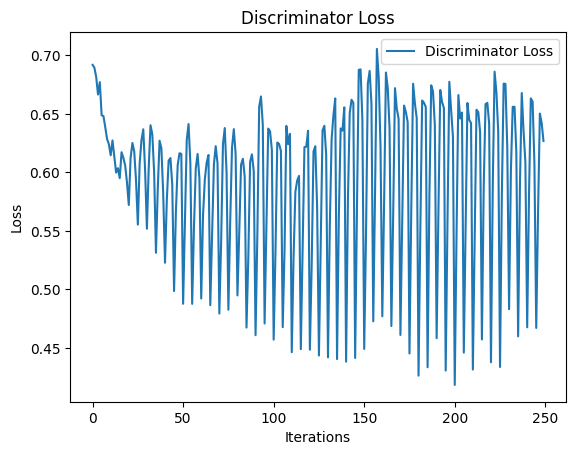

In [ ]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ Discriminator Loss
plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator Loss')
plt.show()


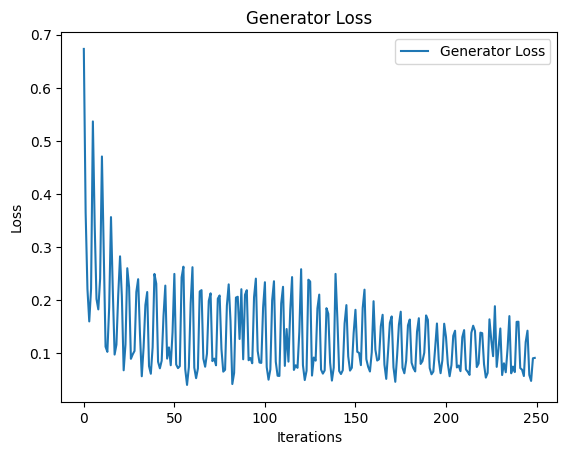

In [ ]:
# Vẽ biểu đồ Generator Loss
plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator Loss')
plt.show()

In [ ]:
# Chuyển đổi dữ liệu thành tensor
tensor_data = torch.tensor(data_transform, dtype=torch.float32).to(device)
latent_vectors = encoder(tensor_data)
# reconstructed_data = decoder(latent_vectors)

# # Chuyển đổi dữ liệu mới thành dạng ban đầu
# generated_data = reconstructed_data.cpu().detach().numpy()

## **Thuật toán LSTM**


In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# 2. dùng latent_vectors làm đầu vào cho LSTM
df1 = latent_vectors.cpu().detach().numpy()


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
20/20 [==============================] - 8s 83ms/step - loss: 0.1711 - val_loss: 0.1871
Epoch 2/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0830 - val_loss: 0.0430
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0048
Epoch 4/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0108 - val_loss: 0.0075
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0095 - val_loss: 0.0069
Epoch 7/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 8/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 9/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0066
Epoch 10/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 11/50
2

In [ ]:
#Doc lai du lieu

# 2. Đọc file csv và gắng index với giá Close
df1 = dataset.reset_index()['Price']


# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)


In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 4ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

## **Đánh giá**

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 10.466122463527656
Testing RMSE: 5.080083527111531
Testing MAE: 3.646465322796616
Validation MAE: 8.000601258042279
Testing MAPE: 2.5059650398515614
Validation MAPE: 4.113629445444246


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    # print(len(temp_input))
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [ ]:
lst_output

[[0.5186550617218018],
 [0.5078740119934082],
 [0.4987865388393402],
 [0.4910713732242584],
 [0.4844813644886017],
 [0.47882354259490967],
 [0.4739447832107544],
 [0.4697220027446747],
 [0.46605512499809265],
 [0.4628620445728302],
 [0.460074782371521],
 [0.4576367139816284],
 [0.45550015568733215],
 [0.4536247253417969],
 [0.45197615027427673],
 [0.45052528381347656],
 [0.4492470920085907],
 [0.44811975955963135],
 [0.4471248984336853],
 [0.44624605774879456],
 [0.44546931982040405],
 [0.4447823762893677],
 [0.44417455792427063],
 [0.44363656640052795],
 [0.4431599974632263],
 [0.4427378475666046],
 [0.44236376881599426],
 [0.44203224778175354],
 [0.4417383372783661],
 [0.4414776563644409]]

## **kẾT QUẢ**

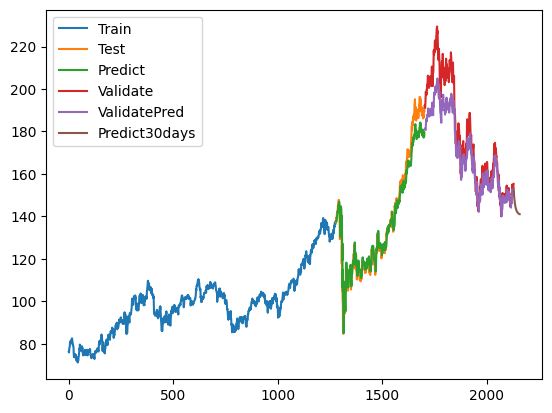

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()